# Working with CGX data using MNE
The goal of this notebook is to import data saved using the [CGX data collection software](http://cognionics.com/wiki/pmwiki.php/Main/DataAcquisitionSoftware), and run through some pre-processing steps using [MNE-Python](https://mne.tools/stable/index.html)!

In [2]:
import mne
import matplotlib.pyplot as plt
import numpy as np

## Path to dataset

In [3]:
DATA_PATH = r'/Users/3x10e8/Documents/GitHub/ac23-eeg/DATA/Aaron/two_tone_stimulus_sandeep3.vhdr'

Audio was played using a speaker, slightly off-center

In [4]:
eog_chans = []
misc_chans = ['ExG 1', 'ExG 2', 'ACC32', 'ACC33', 'ACC34', 'Packet Counter']
stim_chan = ['TRIGGER']
exclude_chans = []
sfreq = 500

if '.bdf' in DATA_PATH:
    print('Reading .bdf file...')
    raw = mne.io.read_raw_bdf(
        DATA_PATH,
        eog = eog_chans, # in case these were used as EMG channels, just to separate from EEG channels
        misc = misc_chans, # keeping aside these as units would be different
        stim_channel = stim_chan, # should get the triggers streamed from the trigger box (if used), not LSL
        exclude = exclude_chans, # both A1 and A2 were used
        preload = True, # load data to memory
    )
    
elif '.vhdr' in DATA_PATH:
    print('Reading .vhdr file...')
    # Move stim and exclude channels to misc to de-clutter usable EEG channels
    # Note annotations get imported from the markers file directly, so we don't need a separate stim channel
    misc_chans.extend(stim_chan) 
    misc_chans.extend(exclude_chans) 
    
    raw = mne.io.read_raw_brainvision(
        vhdr_fname=DATA_PATH,
        eog = eog_chans, # in case these were used as EMG channels, just to separate from EEG channels
        misc = misc_chans, # keeping aside these as units would be different
        #stim_channel = not needed, marker file should be separate
        #exclude = exclude_chans, # assuming only one ground reference was used
        preload = True, # load data to memory
    )

elif '.txt' in DATA_PATH:
    pass # add pandas code and make a raw_io object for CGX software's txt formatting

raw.info

Reading .vhdr file...
Extracting parameters from /Users/3x10e8/Documents/GitHub/ac23-eeg/DATA/Aaron/two_tone_stimulus_sandeep3.vhdr...
Setting channel info structure...
Reading 0 ... 232121  =      0.000 ...   464.242 secs...


<Info | 7 non-empty values
 bads: []
 ch_names: AF7, Fpz, F7, Fz, T7, FC6, Fp1, F4, C4, Oz, CP6, Cz, PO8, CP5, ...
 chs: 30 EEG, 7 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 37
 projs: []
 sfreq: 500.0 Hz
>

In [5]:
ch_idx = {}
for i, ch_name in enumerate(raw.ch_names):
    print(i, ch_name)
    ch_idx[ch_name] = i

0 AF7
1 Fpz
2 F7
3 Fz
4 T7
5 FC6
6 Fp1
7 F4
8 C4
9 Oz
10 CP6
11 Cz
12 PO8
13 CP5
14 O2
15 O1
16 P3
17 P4
18 P7
19 P8
20 Pz
21 PO7
22 T8
23 C3
24 Fp2
25 F3
26 F8
27 FC5
28 AF8
29 A2
30 ExG 1
31 ExG 2
32 ACC32
33 ACC33
34 ACC34
35 Packet Counter
36 TRIGGER


## Apply the 10-20 channel montage

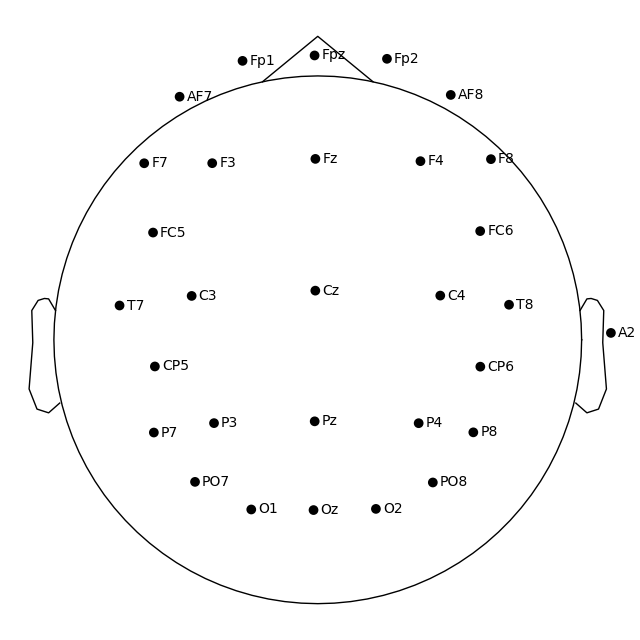

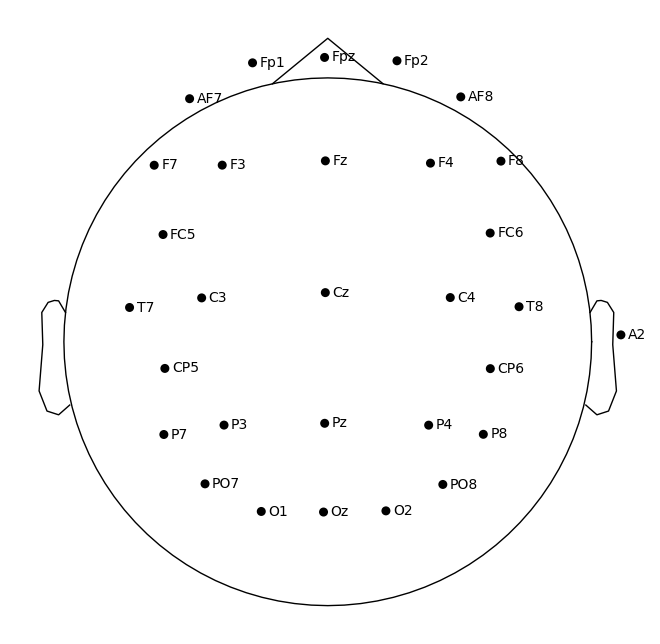

In [6]:
raw.info.set_montage('standard_1020', match_case=False)

# Plot the montage
mne.viz.plot_montage(raw.info.get_montage())

Triggers: 8192 is the onset, it resets to 0

Triggers happened 100ms before the recorded trigger times (must offset)

Using matplotlib as 2D backend.


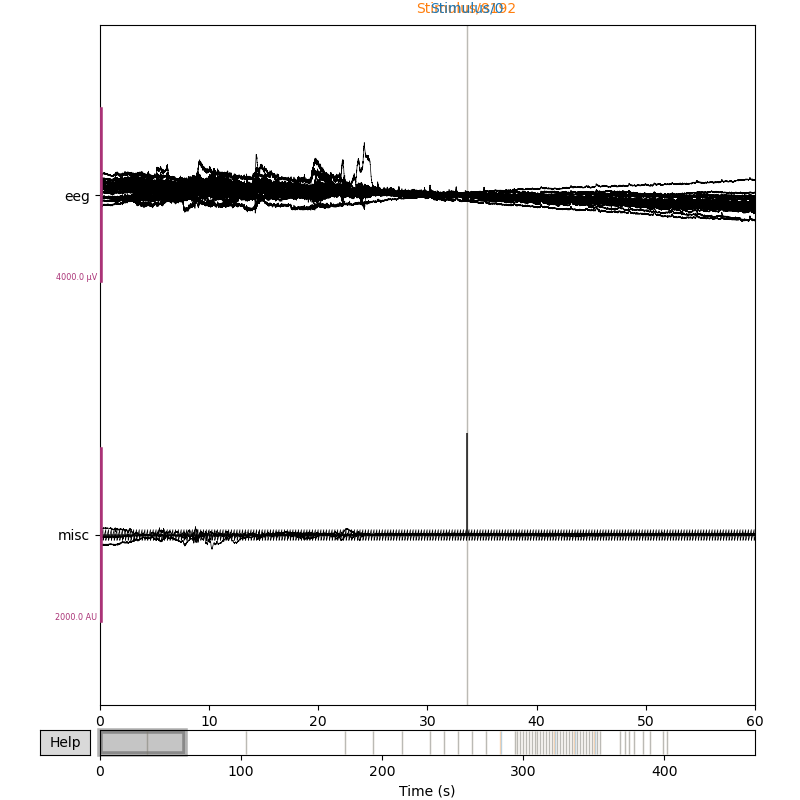

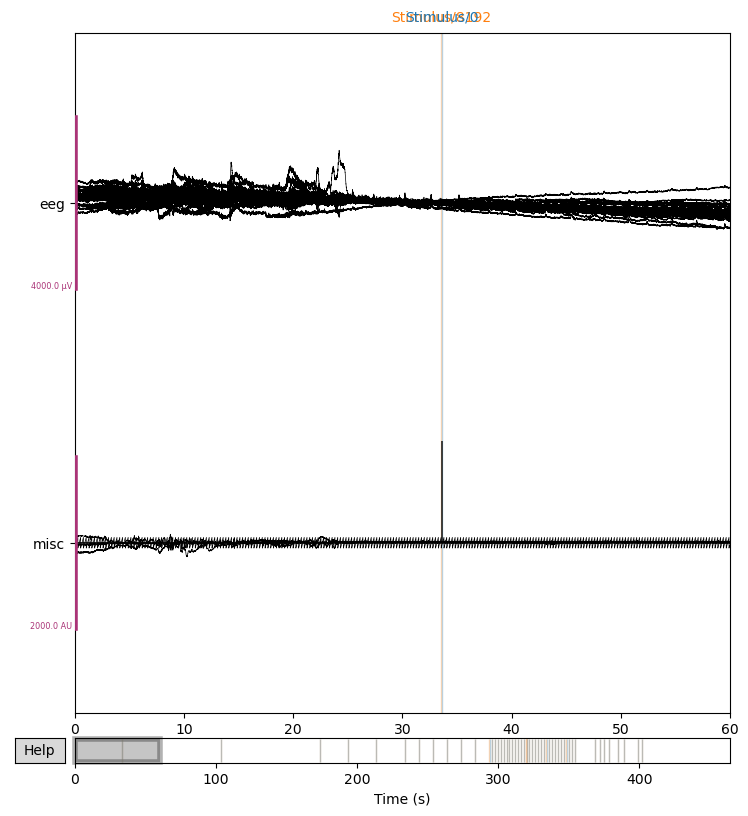

In [7]:
%matplotlib widget

# could go back to 
# %matplotlib inline 
# if the plot doubling becomes annoying

# using widget to make the plot interactive (for scrolling, bad channel selection, etc)

# scaling can help with visibility, especially if we have some bad channels / artifacts
scalings = {
    'eeg': 2000e-6,
    'misc': 1000
} 

# In case you want to manually flag some channels as bad (could also click in the plot)
bad_chans = []
raw.info['bads'] = bad_chans

PLOT_WINDOW_START_s = 0
PLOT_WINDOW_DUR_s = 60

raw.plot(
    scalings = scalings,
    butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

Let's look at a power spectrum (before we do any filtering):

Effective window size : 16.384 (s)


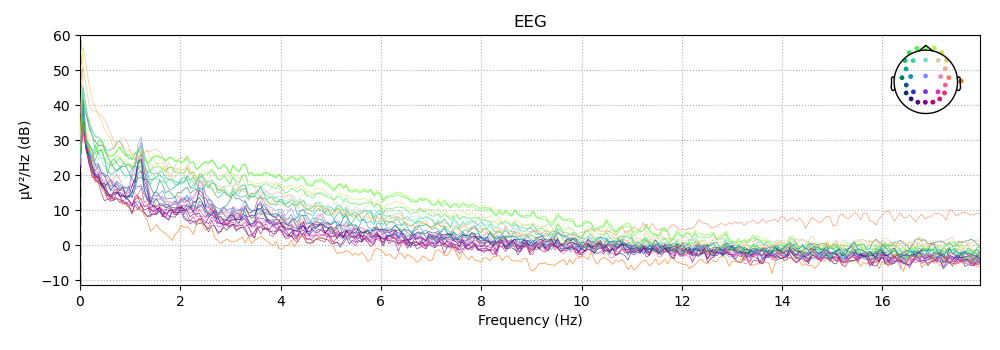

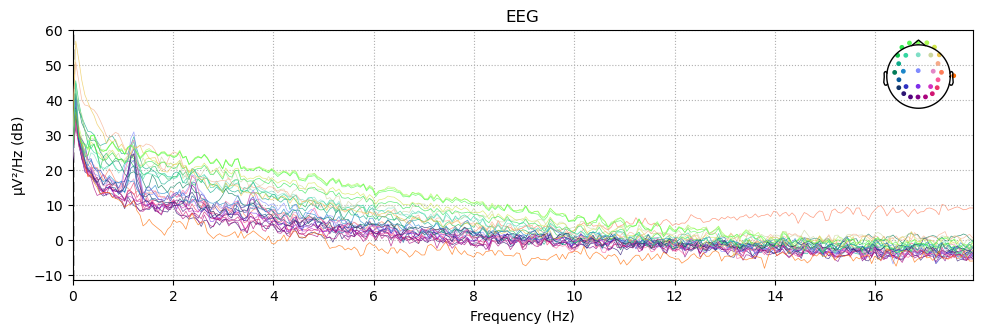

In [15]:
n_fft = 1024*2*2*2
fmin = 0
fmax = 18

raw.compute_psd(
    n_fft = n_fft,
    fmin = fmin,
    fmax = fmax,
).plot(average = False)

Let's notch power supply noise:

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 3.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Effective window size : 16.384 (s)


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


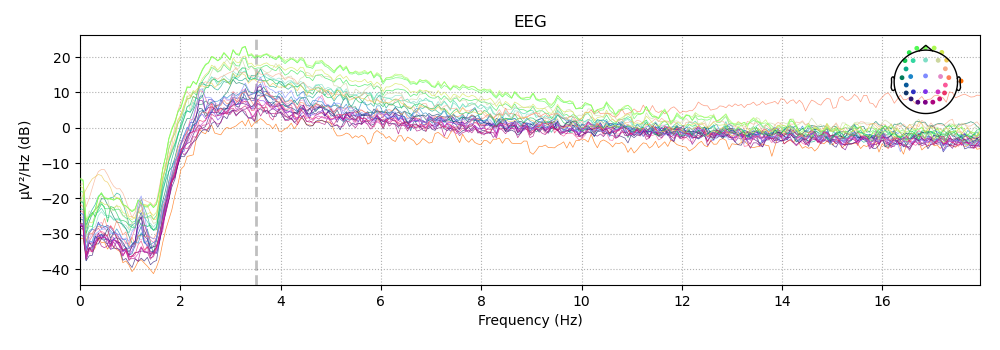

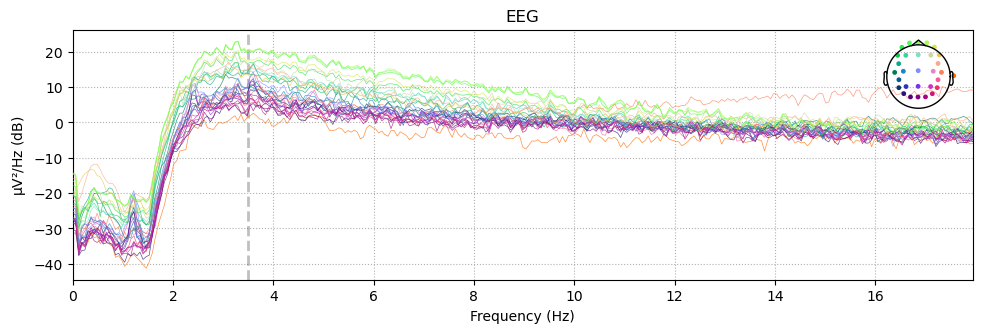

In [20]:
# Notch filter
raw_filt = raw.copy().notch_filter( # make a copy of the array to avoid modifying in place
    freqs = [60, 120, 180, 240]
)


# Highpass filter
raw_filt = raw_filt.filter( # make a copy of the array to avoid modifying in place
    l_freq = 3.5, # lower cut-off, in Hz
    h_freq = None, # upper cut-off, in Hz
)

# And look at the PSD again
# n_fft = 1024

# picks = [''] # a list of channels that you want to focus on, if any
raw_filt.compute_psd(
    # picks= picks,
    fmin = fmin, # lower limit to plot
    fmax = fmax, # upper limit to plot
    # tmin = 0, # if only using a subset of the data for PSD computation
    # tmax = 10,
    n_fft = n_fft,
).plot()

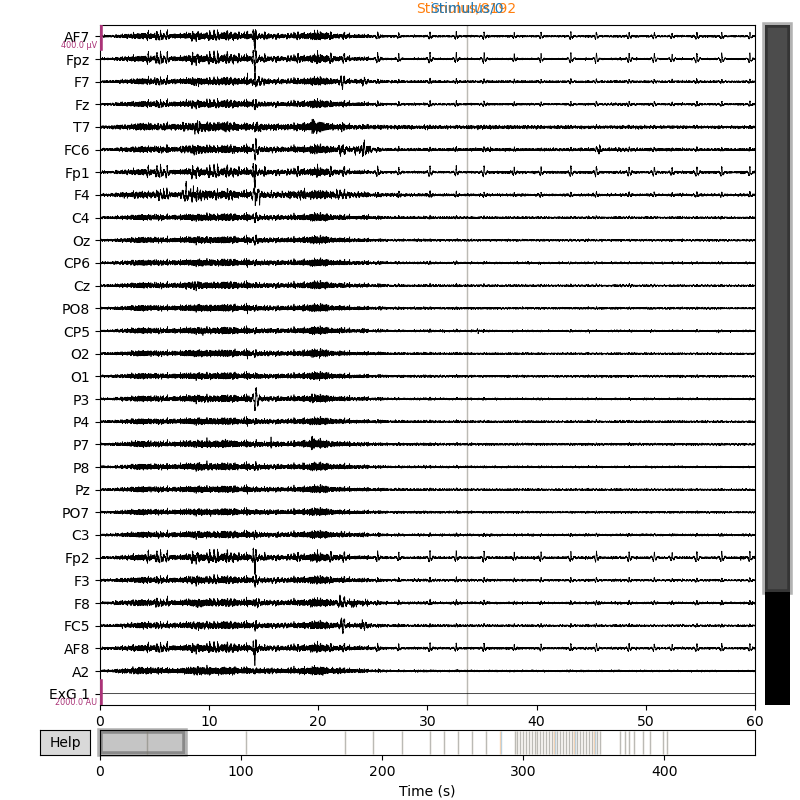

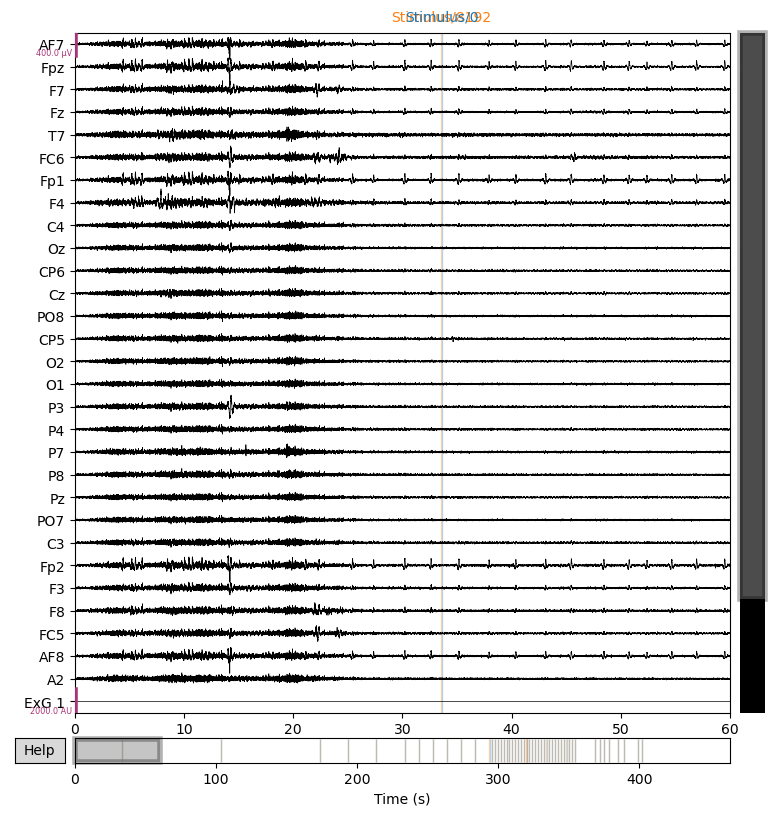

In [21]:
## Update scalings if needed
scalings['eeg'] = 200e-6 
# scalings['misc'] = 100

raw_filt.info.bads = ['T8'] # ideally could label bad segments instead of dropping channels

# Drop bad channels from visual examination before running ICA
raw_filt_drop_bad = raw_filt.copy().drop_channels(raw_filt.info.bads)

raw_filt_drop_bad.plot(
    scalings = scalings,
    n_channels = 30,
    #butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

# Run ICA to remove artifacts
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#sphx-glr-auto-tutorials-preprocessing-40-artifact-correction-ica-py

In [22]:
from mne.preprocessing import ICA

# Make an ICA object
ica = ICA(
    #n_components = 29, # number of prinicipal components passed to ICA
    random_state = 23, # seed for numpy RNG
    #method = 'infomax', # can use 'fastica' or 'picard' too
)

# Run ICA
ica.fit(raw_filt_drop_bad)

Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 29 components
Fitting ICA took 6.1s.


<ICA | raw data decomposition, method: fastica (fit in 55 iterations on 232122 samples), 29 ICA components (29 PCA components available), channel types: eeg, no sources marked for exclusion>

## Plot ICA components over time

Creating RawArray with float64 data, n_channels=29, n_times=232122
    Range : 0 ... 232121 =      0.000 ...   464.242 secs
Ready.


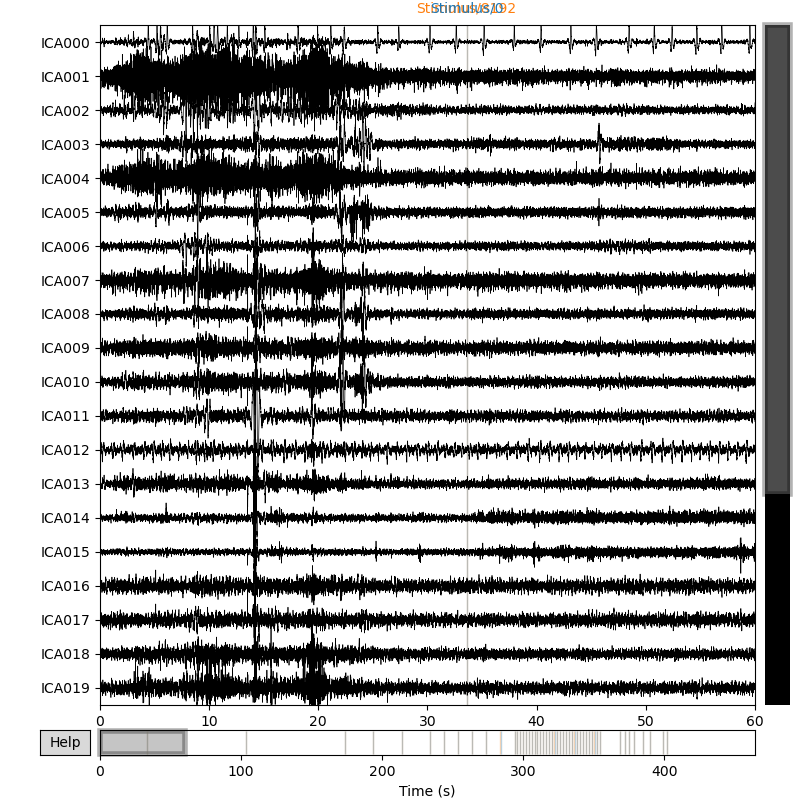

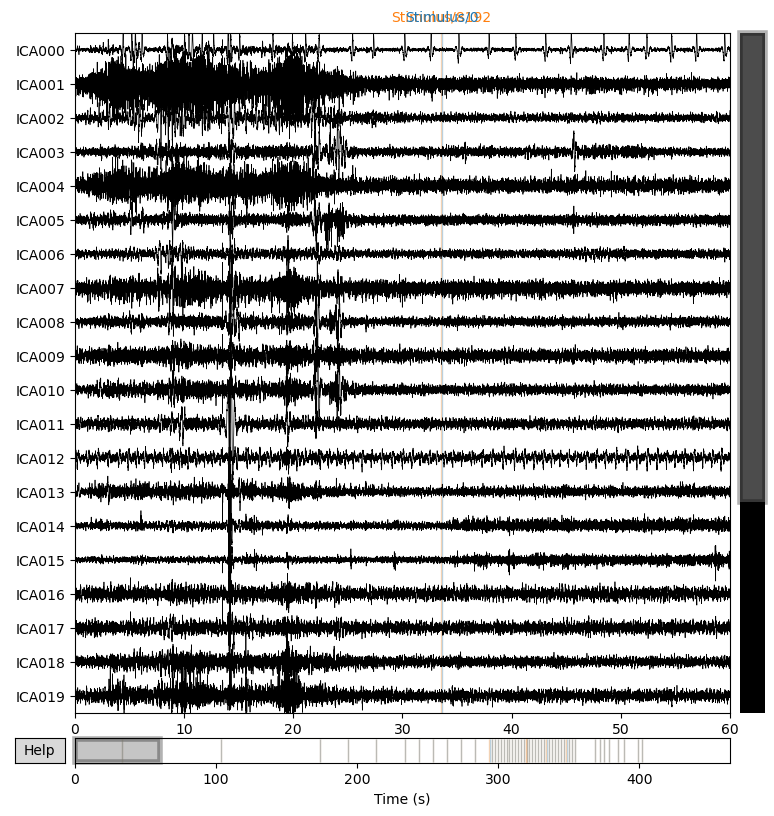

In [23]:
%matplotlib widget

ica.plot_sources(
    raw_filt_drop_bad,
    start = PLOT_WINDOW_START_s,
    stop = PLOT_WINDOW_START_s + PLOT_WINDOW_DUR_s,
)

## Topomaps for each ICA component

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated


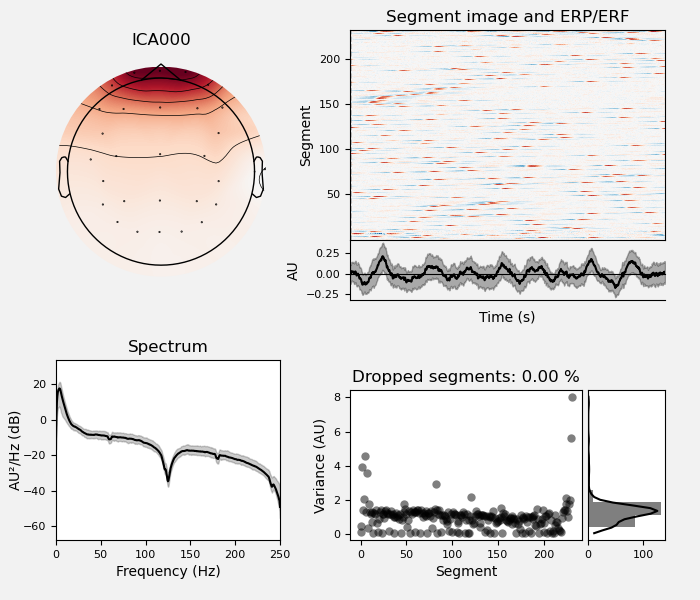

[<Figure size 700x600 with 6 Axes>]

In [25]:
suspect_ica_components = [
    0, # eye blinks
    # pulse
]

ica.plot_properties(
    raw_filt_drop_bad,
    picks = suspect_ica_components
)

## Remove suspect ICA components

Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 1 ICA component
    Projecting back using 29 PCA components


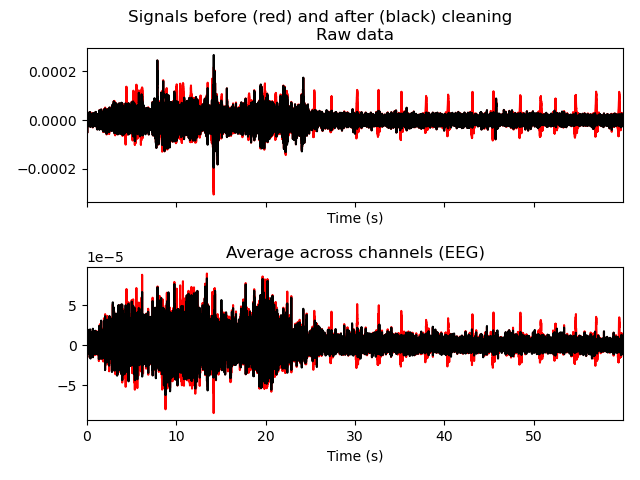

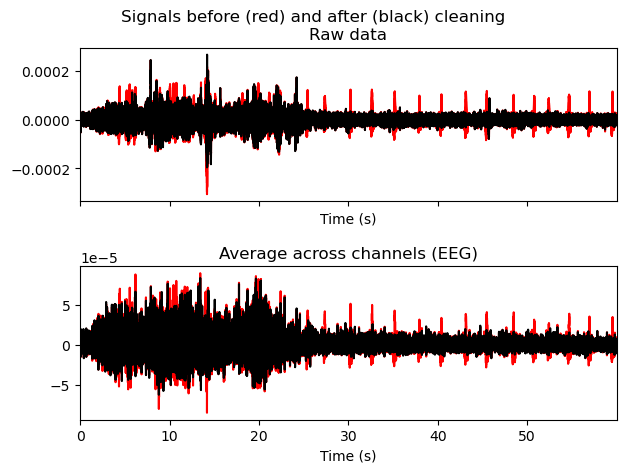

In [26]:
ica.plot_overlay(
    raw_filt_drop_bad,
    exclude = suspect_ica_components,
    start = 0, # this is index, not seconds
    stop = int(raw_filt_drop_bad.info['sfreq']) * 60,
)


## Project back to channel space

In [27]:
raw_ica = ica.apply(
    raw_filt_drop_bad, 
    exclude=suspect_ica_components, # ICA components to drop
)

Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 1 ICA component
    Projecting back using 29 PCA components


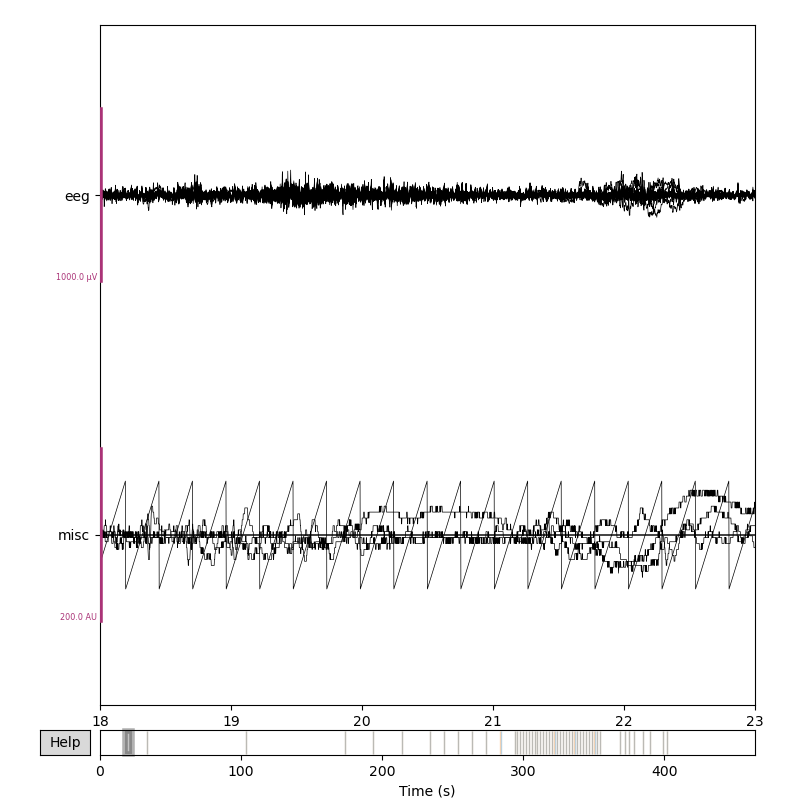

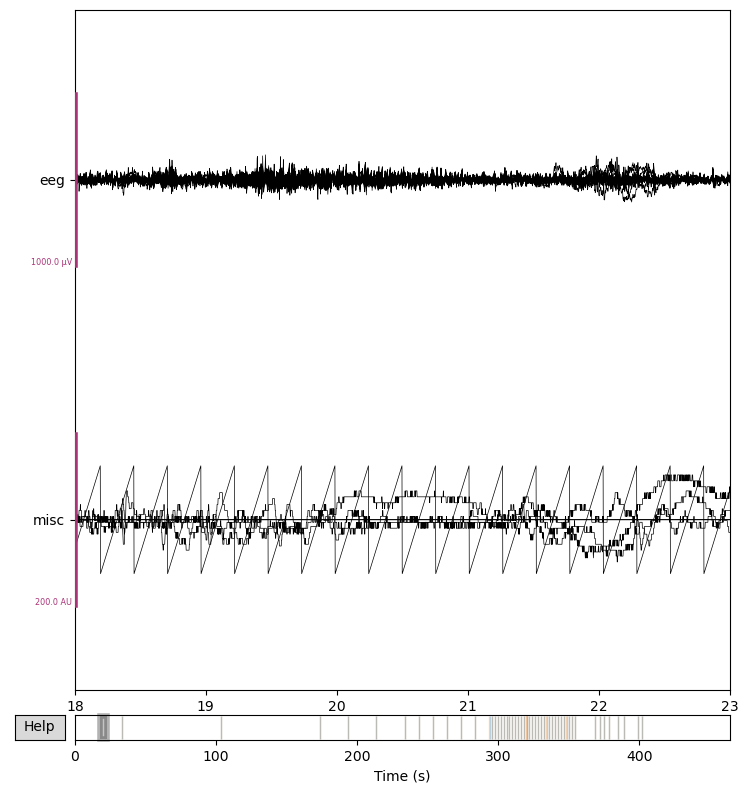

In [28]:
scalings = {
    'eeg': 500e-6, 
    'misc': 1e2,
} 

raw_ica.plot(
    scalings=scalings,
    butterfly=True,
    duration=5,
    start=18,
)

# Find event markers

In [29]:
events, event_ids = mne.events_from_annotations(raw_ica)

Used Annotations descriptions: ['Stimulus/0', 'Stimulus/8192']


In [30]:
event_ids

{'Stimulus/0': 10001, 'Stimulus/8192': 10002}

In [31]:
events[:, 0] -= int(0.1*sfreq) #correct offset of 100ms

In [32]:
# skip all the "0" events
on_events = events[events[:, 2] == event_ids['Stimulus/8192']]
event_ids.pop('Stimulus/0', None) 

10001

In [33]:
# split the on events in two (alternating up/down events)
on_events[:, 2][::2] = 10003
event_ids['Stimulus/Flip'] = 10003

In [34]:
event_ids

{'Stimulus/8192': 10002, 'Stimulus/Flip': 10003}

In [35]:
on_events

array([[ 16742,      0,  10003],
       [ 51765,      0,  10002],
       [ 86788,      0,  10003],
       [ 96796,      0,  10002],
       [106804,      0,  10003],
       [116808,      0,  10002],
       [121816,      0,  10003],
       [126828,      0,  10002],
       [131836,      0,  10003],
       [136844,      0,  10002],
       [141851,      0,  10003],
       [146859,      0,  10002],
       [147867,      0,  10003],
       [148875,      0,  10002],
       [149887,      0,  10003],
       [150899,      0,  10002],
       [151911,      0,  10003],
       [152923,      0,  10002],
       [153935,      0,  10003],
       [154947,      0,  10002],
       [155959,      0,  10003],
       [156971,      0,  10002],
       [157983,      0,  10003],
       [158995,      0,  10002],
       [160003,      0,  10003],
       [161015,      0,  10002],
       [162027,      0,  10003],
       [163039,      0,  10002],
       [164051,      0,  10003],
       [165063,      0,  10002],
       [16

# Time Feqency Analysis
https://mne.tools/stable/generated/mne.time_frequency.tfr_array_morlet.html

In [36]:
START_TIME = 30
END_TIME = -30

In [37]:
if 1: # takes too long to run?
    sfreq = 500
    eps = raw_ica[:][0] # one epoch for the entire duration

    #freqs = np.arange(10, 100, .5)
    freqs = np.arange(3, 8, .1)

    power = mne.time_frequency.tfr_array_morlet(
        eps[np.newaxis, :, sfreq*START_TIME:sfreq*END_TIME], #(n_epochs, n_channels, n_times)
        freqs=freqs,
        n_cycles=len(freqs)*2,
        sfreq=sfreq,
        #picks='eeg',
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   30.7s finished


In [66]:
# Get the bin idx for 4 and 7 Hz
f1_bin_4Hz = np.where(np.abs(freqs - 4) < 0.01)[0][0]
f1_bin_7Hz = np.where(np.abs(freqs - 7) < 0.01)[0][0]

# Get indices of side-bands for both tones
num_ssb_bins = 3 # num bins on one side
sb_bin_4Hz = list(range(f1_bin_4Hz-num_ssb_bins, f1_bin_4Hz+num_ssb_bins + 1)) #[f1_bin_4Hz]
sb_bin_4Hz.remove(f1_bin_4Hz)

sb_bin_7Hz = list(range(f1_bin_7Hz-num_ssb_bins, f1_bin_7Hz+num_ssb_bins + 1)) #[f1_bin_4Hz]
sb_bin_7Hz.remove(f1_bin_7Hz)

#sb_bin_7Hz = f1_bin_4Hz-num_ssb_bins : f1_bin_4Hz+num_ssb_bins

print(f1_bin_4Hz, sb_bin_4Hz)
print(f1_bin_7Hz, sb_bin_7Hz)

10 [7, 8, 9, 11, 12, 13]
40 [37, 38, 39, 41, 42, 43]


In [71]:
power[0][:, f1_bin_4Hz].shape #[:][f1_bin_4Hz].shape

(36, 202122)

In [72]:
power[0][:, sb_bin_4Hz].shape #[:][f1_bin_4Hz].shape

(36, 6, 202122)

In [43]:
power.shape

(1, 36, 50, 202122)

[ 30.     30.002  30.004 ... 434.238 434.24  434.242]
(202123,) (51,) (50, 202122)


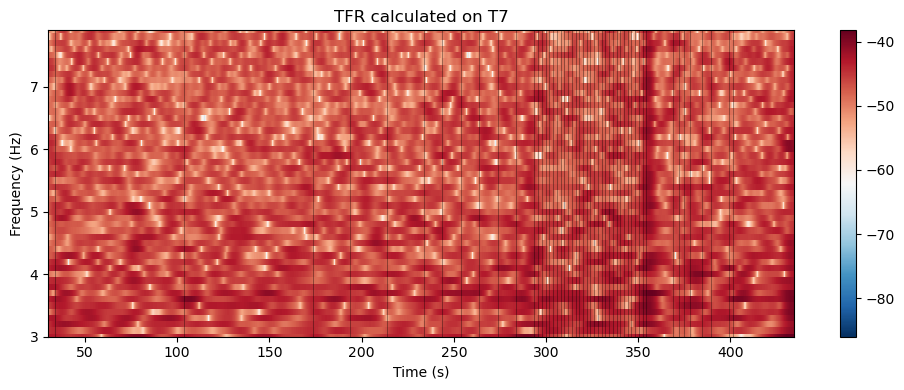

(202123,) (51,) (50, 202122)


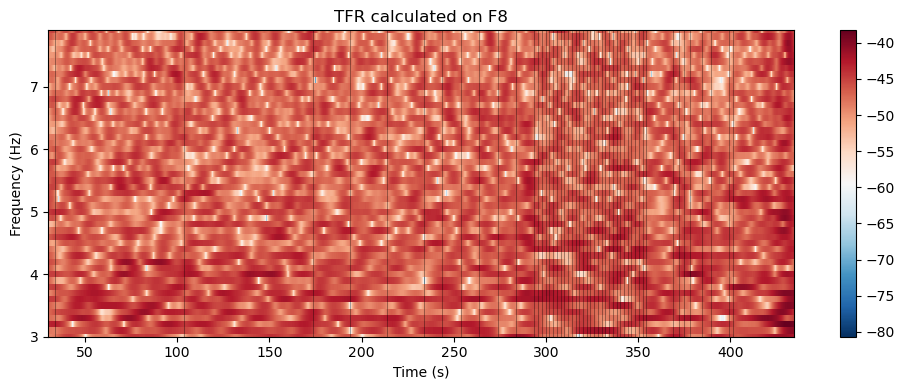

(202123,) (51,) (50, 202122)


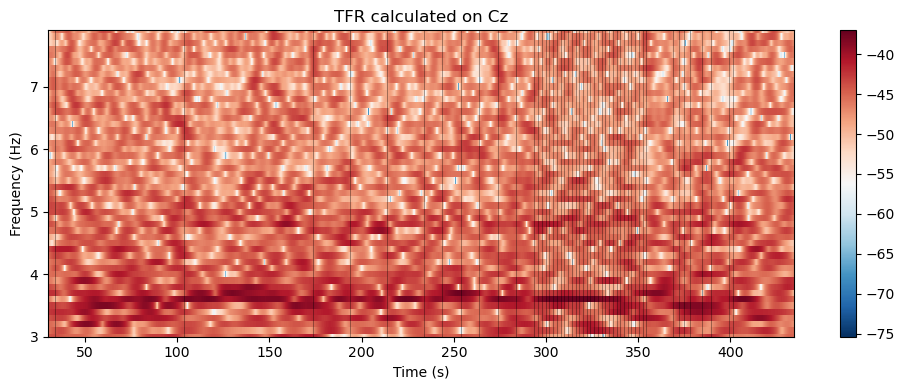

(202123,) (51,) (50, 202122)


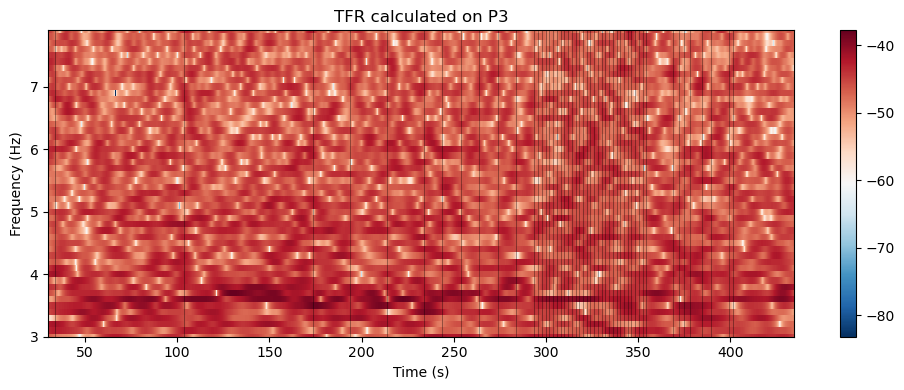

In [38]:
%matplotlib inline

from mne.baseline import rescale
from mne.viz import centers_to_edges

times = raw[:][1][sfreq*START_TIME:sfreq*END_TIME]
print(times)

# Baseline the output
#rescale(power, times, (0., 0.1), mode='mean', copy=False)

for ch in [
    ch_idx['T7'],
    ch_idx['F3'],
    ch_idx['Cz'], 
    ch_idx['P3'], 
    #ch_idx['Oz'], 
]:
    
    ch_name = raw_ica.ch_names[ch]
    
    fig, ax = plt.subplots(figsize=(10,4))
    x, y = centers_to_edges(times, freqs)
    print(x.shape, y.shape, power[0][ch].shape)

    mesh = ax.pcolormesh(x, y, 10*np.log10(np.abs(power[0][ch])), cmap='RdBu_r', 
                         #vmin=vmin, vmax=vmax,
                        )
    ax.set_title(f'TFR calculated on {ch_name}')
    ax.set(ylim=freqs[[0, -1]], xlabel='Time (s)', ylabel='Frequency (Hz)')

    '''
    for t_span in t_motion_spans:
        ax.axvspan(t_span[0], t_span[1], alpha=0.1, color='yellow')
    '''  

    fig.colorbar(mesh)
    
    for ev in on_events:
        plt.axvline(
            x=ev[0]/sfreq, # 100 ms offset from hardware
            c='k', 
            ls='-', 
            lw=0.5, 
            alpha=0.5
        )
    
    plt.tight_layout()

    plt.show()

# ERPs

In [39]:
# Get epochs

eps = mne.Epochs(
    #raw_filt,
    raw_ica.copy().filter(l_freq=0.1, h_freq=None), # high pass filter to remove DC
    events = on_events, 
    event_id = event_ids, 
    tmin=-3,
    tmax=3,
    baseline=None,
)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16501 samples (33.002 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.3s finished


Stimulus/8192
No projector specified for this dataset. Please consider the method self.add_proj.


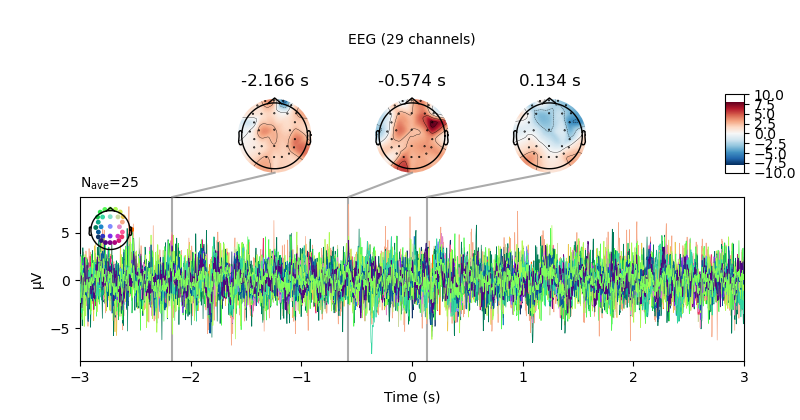

Stimulus/Flip
No projector specified for this dataset. Please consider the method self.add_proj.


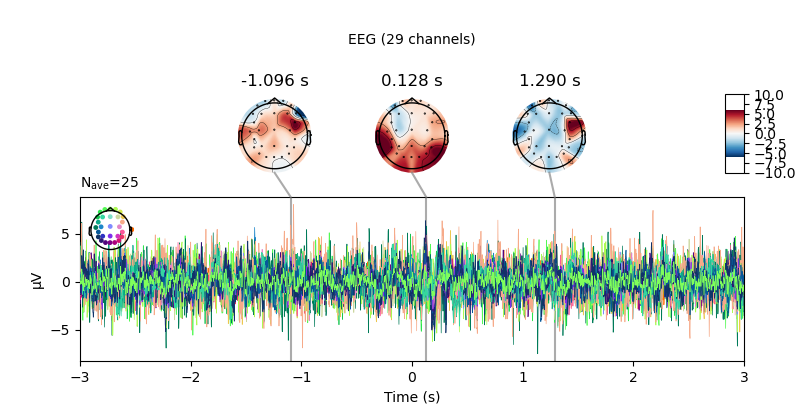

In [40]:
%matplotlib widget 

for ev_id in event_ids:
    print(ev_id)
    
    eps[ev_id].average(
        #picks = ['Cz']
    ).plot_joint(
        #times = [-1.78, -1.38, 0.352, 0.65] #"peaks"
    )

Stimulus/8192
Using data from preloaded Raw for 25 events and 3001 original time points ...
0 bad epochs dropped
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


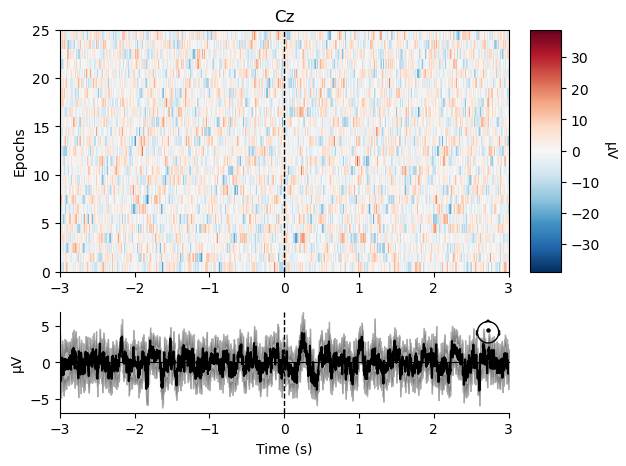

Stimulus/Flip
Using data from preloaded Raw for 25 events and 3001 original time points ...
0 bad epochs dropped
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


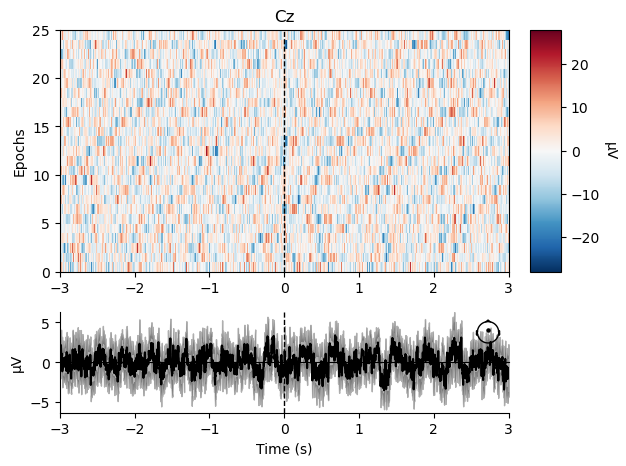

In [41]:
%matplotlib inline

for ev_id in event_ids:
    print(ev_id)
    eps[ev_id].plot_image(
        picks = ['Cz'], # , 'F3', 'P3'],
    ) #combine='mean'

Stimulus/8192
Using data from preloaded Raw for 25 events and 3001 original time points ...
0 bad epochs dropped
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


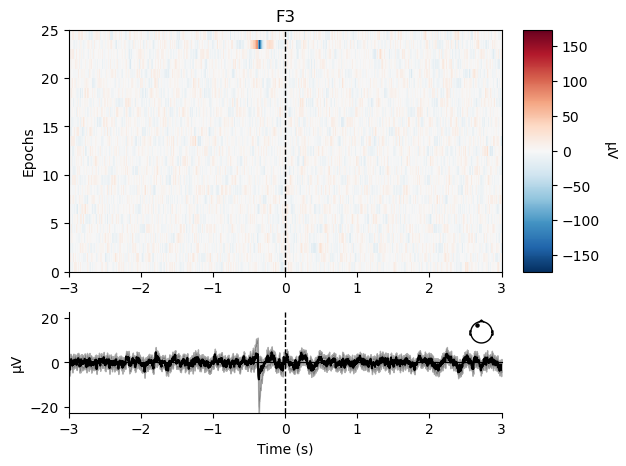

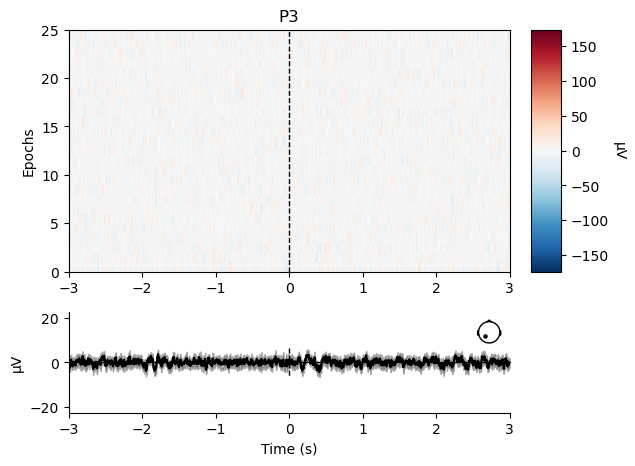

Stimulus/Flip
Using data from preloaded Raw for 25 events and 3001 original time points ...
0 bad epochs dropped
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


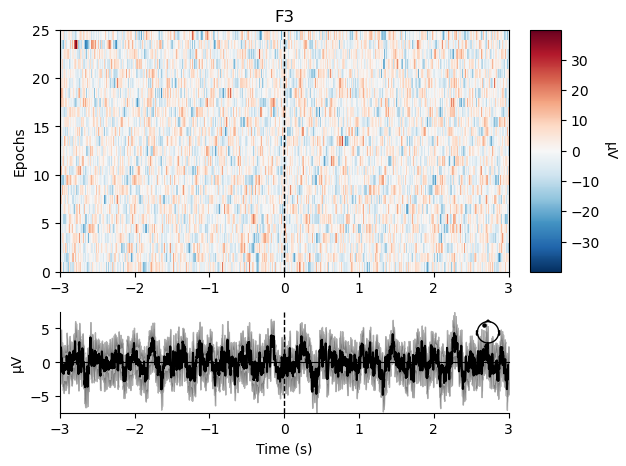

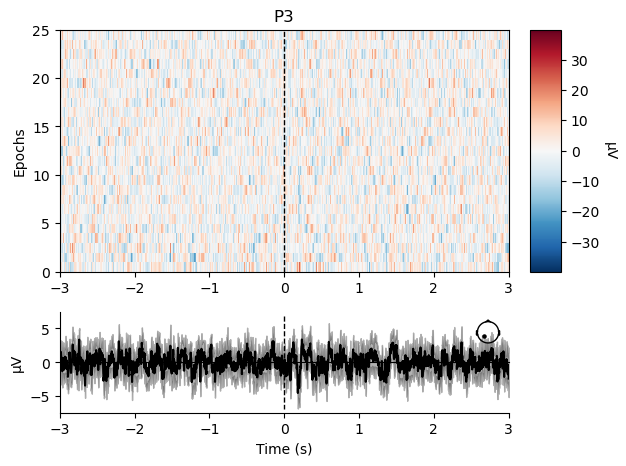

In [42]:
for ev_id in event_ids:
    print(ev_id)
    
    eps[ev_id].plot_image(
        picks = ['F3', 'P3'],
        #combine='mean')
)